In [1]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
ls drive/MyDrive/"Colab Notebooks"/data/

hlm_df.csv             submission.csv    train.csv
mlm_df.csv             test.csv          train_fps_mol.csv
preprocessed_data.csv  test_fps_mol.csv
sample_submission.csv  test_smile.csv


In [ ]:
path =  "drive/MyDrive/Colab Notebooks/data/"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings("ignore")
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole     # 화면에 출력하기 위한 옵션
IPythonConsole.ipython_useSVG=True

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [ ]:
df = pd.read_csv(path + 'preprocessed_data.csv')
df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3487 entries, 0 to 3486
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          3487 non-null   object 
 1   SMILES                      3487 non-null   object 
 2   MLM                         3487 non-null   float64
 3   HLM                         3487 non-null   float64
 4   AlogP                       3485 non-null   float64
 5   Molecular_Weight            3487 non-null   float64
 6   Num_H_Acceptors             3487 non-null   int64  
 7   Num_H_Donors                3487 non-null   int64  
 8   Num_RotatableBonds          3487 non-null   int64  
 9   LogD                        3487 non-null   float64
 10  Molecular_PolarSurfaceArea  3487 non-null   float64
 11  fps                         3487 non-null   object 
 12  mol                         3487 non-null   object 
dtypes: float64(6), int64(3), object(4

In [ ]:
df.isnull().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         2
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
fps                           0
mol                           0
dtype: int64

In [ ]:
idx_null = df[df['AlogP'].isnull()].index
idx_null

Int64Index([2788, 3377], dtype='int64')

In [ ]:
df = df.drop(idx_null, axis=0)
df.isnull().sum()

id                            0
SMILES                        0
MLM                           0
HLM                           0
AlogP                         0
Molecular_Weight              0
Num_H_Acceptors               0
Num_H_Donors                  0
Num_RotatableBonds            0
LogD                          0
Molecular_PolarSurfaceArea    0
dtype: int64

In [ ]:
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['num_of_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_of_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [ ]:
df.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,fps,mol,num_of_atoms,num_of_heavy_atoms
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,117.37,[0. 0. 0. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7983843f3920>,52,28
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,73.47,[0. 0. 0. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7983843f3990>,40,21
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,62.45,[0. 0. 0. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7983843f3a00>,41,22
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,92.60,[0. 0. 1. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7983843f3a70>,69,35
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,42.43,[0. 0. 0. ... 0. 0. 0.],<rdkit.Chem.rdchem.Mol object at 0x7983843f3ae0>,36,20


In [ ]:
# 탄소 패턴을 지정한다
c_patt = Chem.MolFromSmiles('C')

# 이 패턴이 들어있는 곳을 찾는다. 패턴의 수를 세면 탄소 원자가 몇개 들어있는지 알 수 있다
print(df['mol'][0].GetSubstructMatches(c_patt))

((0,), (1,), (3,), (4,), (5,), (6,), (7,), (9,), (11,), (12,), (13,), (14,), (16,), (17,), (19,), (20,), (23,), (24,), (26,), (27,))


In [ ]:
# 임의의 패턴(원자)를 몇개 포함하고 있는지를 얻는 함수
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['mol'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl'], df)

# HLM, MLM 분리 시키기

In [ ]:
df.columns

Index(['id', 'SMILES', 'MLM', 'HLM', 'AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'fps', 'mol', 'num_of_atoms',
       'num_of_heavy_atoms', 'num_of_C_atoms', 'num_of_O_atoms',
       'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')

In [ ]:
x_columns = ['AlogP', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'num_of_atoms', 'num_of_heavy_atoms',
       'num_of_C_atoms', 'num_of_O_atoms','num_of_N_atoms', 'num_of_Cl_atoms']
y_columns = ['MLM', 'HLM']

In [ ]:
df[y_columns[0]].values

array([2.601e+01, 2.927e+01, 5.586e+00, ..., 5.615e+01, 3.000e-02,
       4.500e-01])

In [ ]:
train_df = df[x_columns]
test_mlm = df[y_columns[0]].values
test_hlm = df[y_columns[1]].values

In [ ]:
train_df.shape, test_mlm.shape, test_hlm.shape

((3496, 13), (3496,), (3496,))

In [ ]:
test_mlm.values

array([2.601e+01, 2.927e+01, 5.586e+00, ..., 5.615e+01, 3.000e-02,
       4.500e-01])

# Split

In [ ]:
Xm_train, Xm_val, ym_train, ym_val = train_test_split(train_df, test_mlm, test_size=.2)

In [ ]:
Xh_train, Xh_val, yh_train, yh_val = train_test_split(train_df, test_hlm, test_size=.2)

In [ ]:
Xm_train.shape, Xm_val.shape, ym_train.shape, ym_val.shape,\
Xh_train.shape, Xh_val.shape, yh_train.shape, yh_val.shape

((2788, 13),
 (697, 13),
 (2788,),
 (697,),
 (2788, 13),
 (697, 13),
 (2788,),
 (697,))

In [ ]:
ym_val.name, yh_val.name

('MLM', 'HLM')

In [ ]:
sns.set_style('whitegrid')

# RMSE + 그래프

In [ ]:
def show_reg_result(y_test, y_pred, N=50):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    # print(f'{y_test.name}의 RMSE:', round(rmse, 4))
    # print(f'{y_test.name}의 RMSE * 0.5 :', round(rmse * 0.5, 4))
    print(f' RMSE:', round(rmse, 4))
    print(f' RMSE * 0.5 :', round(rmse * 0.5, 4))

    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
      plt.legend()
      plt.ylabel("Liver Microsome")
      plt.show()

# Max_Depth 몇으로 할까?

In [ ]:
def find_max_depth(X_train, X_test, y_train, y_test):
    for depth in range(1,50):
        dtr = DecisionTreeRegressor(max_depth=depth)
        dtr.fit(X_train, y_train)
        print(depth, dtr.score(X_test, y_test).round(3))

In [ ]:
find_max_depth(Xm_train, Xm_val, ym_train, ym_val)

In [ ]:
find_max_depth(Xh_train, Xh_val, yh_train, yh_val)

# HLM 예측 모델 만들기

In [ ]:
(33.6858 + 32.7663 + 32.777)/3

33.076366666666665

 RMSE: 33.6858
 RMSE * 0.5 : 16.8429


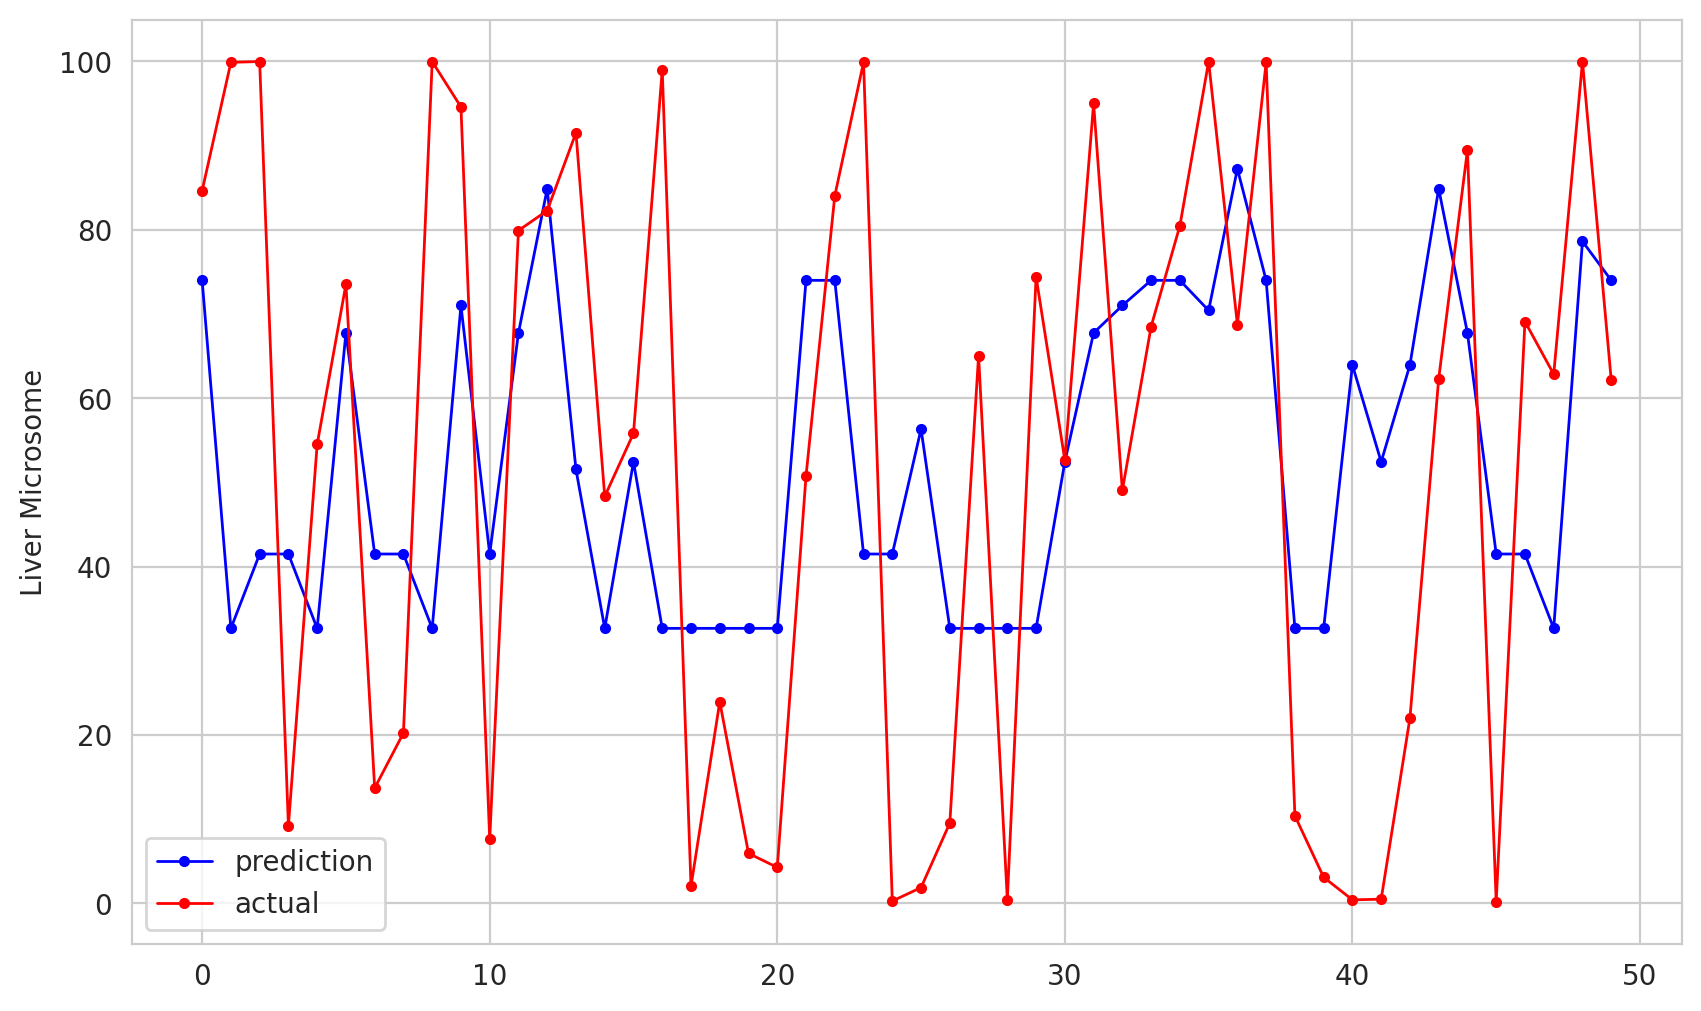

In [ ]:
# 결정 트리 회귀 모델
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(Xh_train, yh_train)
y_pred = dtr.predict(Xh_val)
show_reg_result(yh_val, y_pred)

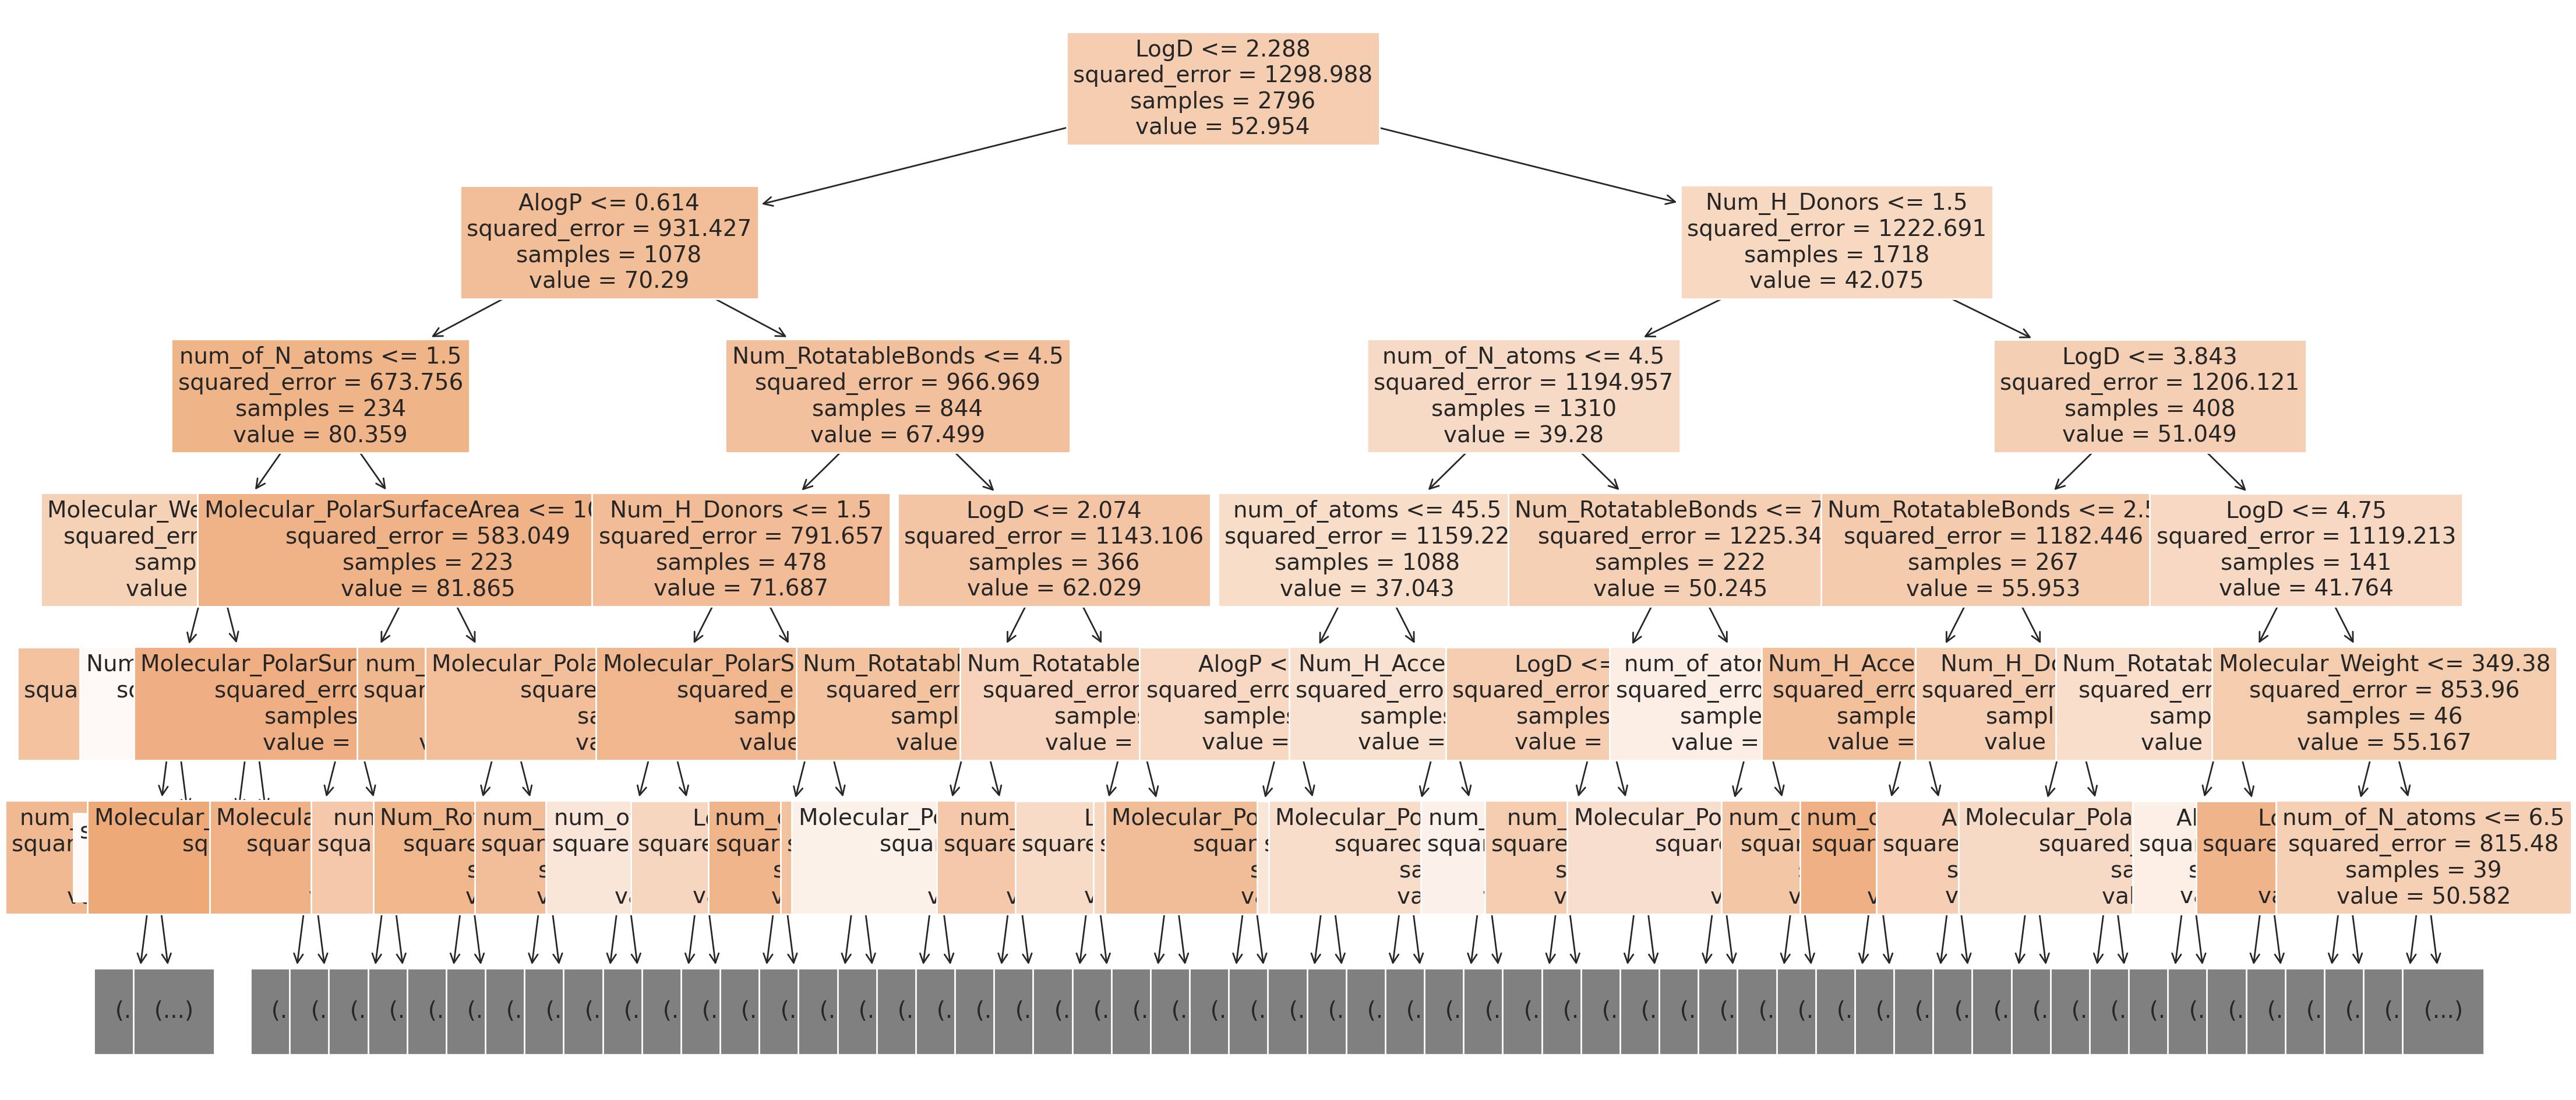

In [ ]:
from sklearn import tree
plt.figure(figsize=(26,12))

tree.plot_tree(dtr, fontsize=14,
              feature_names=train_df.columns,
              filled=True,
              impurity=True,
              max_depth=5)
plt.show()


 RMSE: 32.7663
 RMSE * 0.5 : 16.3832


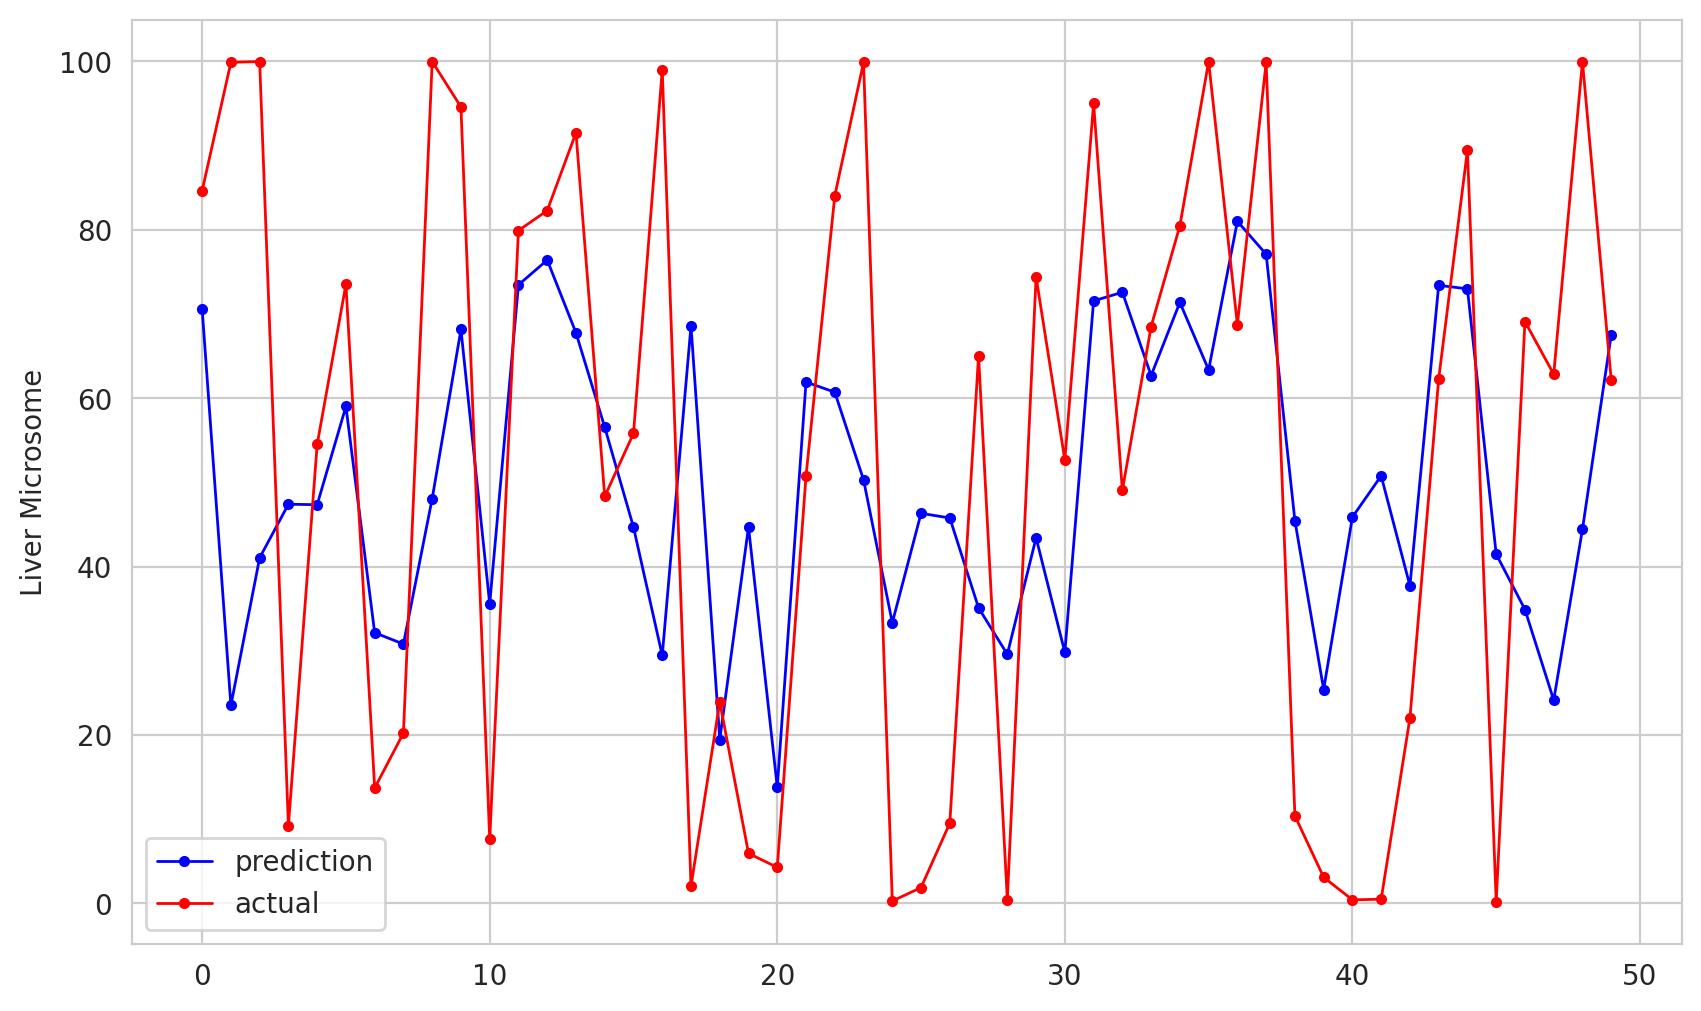

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(Xh_train, yh_train)
y_pred = rfr.predict(Xh_val)
show_reg_result(yh_val, y_pred)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1219
[LightGBM] [Info] Number of data points in the train set: 2788, number of used features: 13
[LightGBM] [Info] Start training from score 53.019792
 RMSE: 32.777
 RMSE * 0.5 : 16.3885


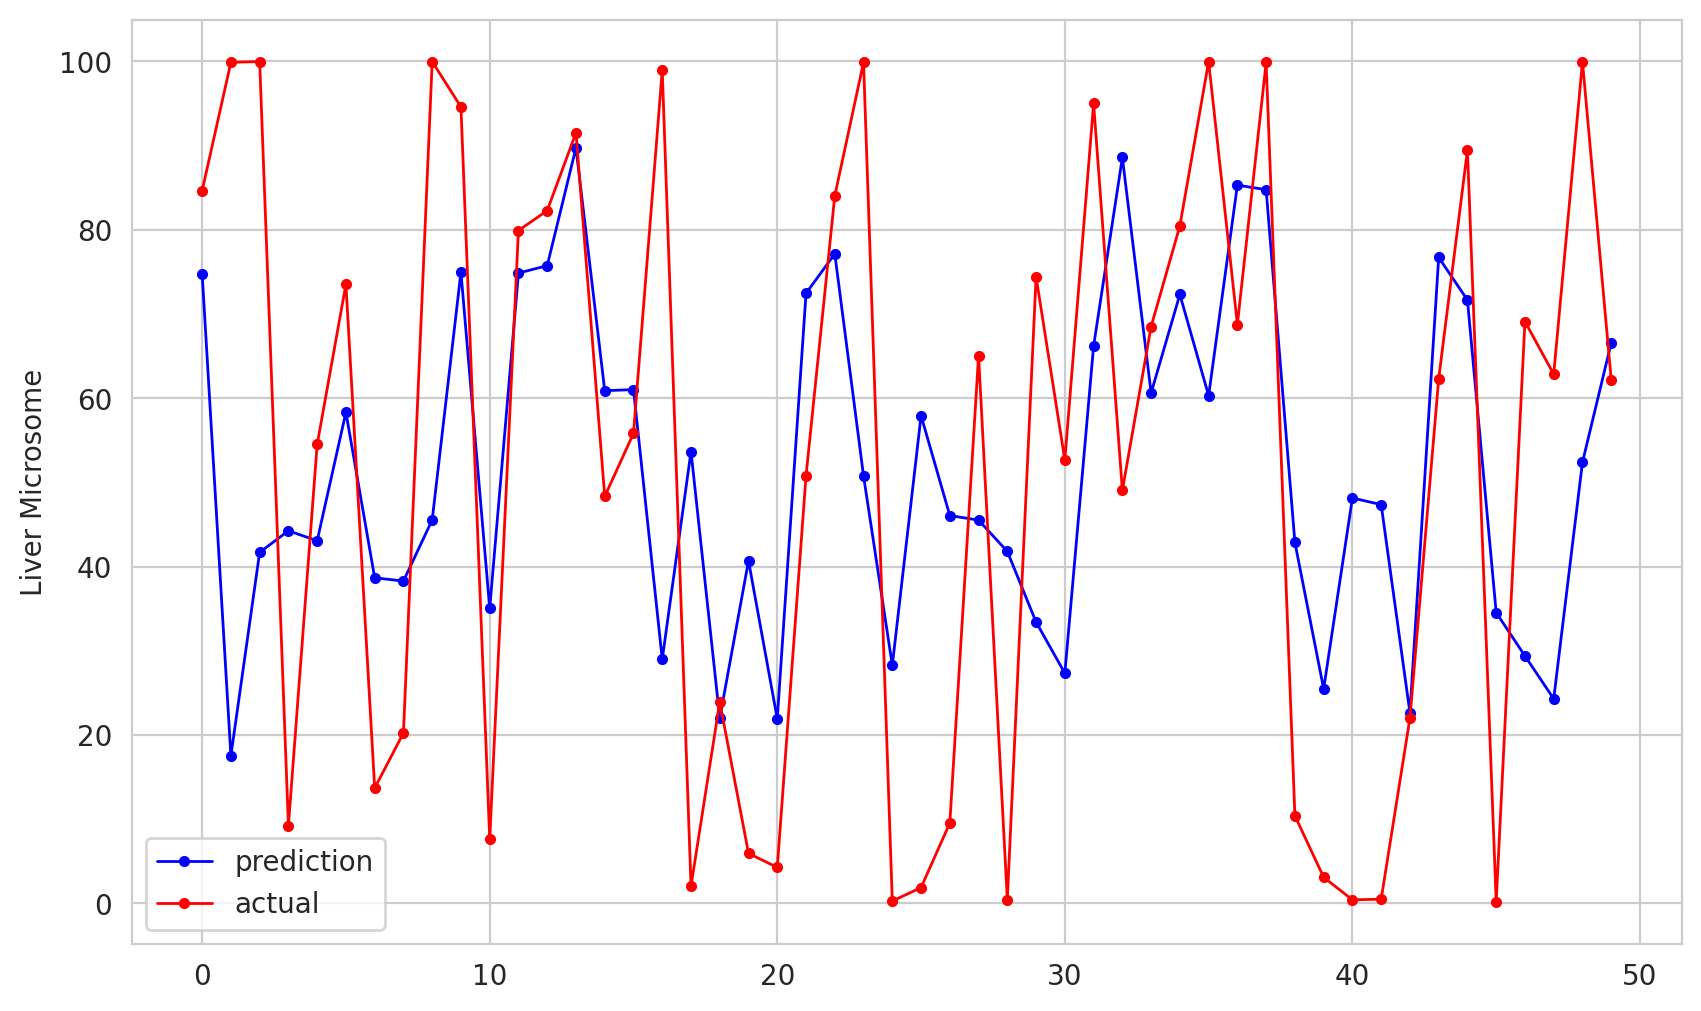

In [ ]:
from lightgbm import LGBMRegressor
lgbm_r = LGBMRegressor()
lgbm_r.fit(Xh_train, yh_train)
y_pred = lgbm_r.predict(Xh_val)
show_reg_result(yh_val, y_pred)

In [ ]:
test_df = pd.read_csv(path + 'test.csv')

In [ ]:
test_df['mol'] = test_df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
test_df['mol'] = test_df['mol'].apply(lambda x: Chem.AddHs(x))
test_df['num_of_atoms'] = test_df['mol'].apply(lambda x: x.GetNumAtoms())
test_df['num_of_heavy_atoms'] = test_df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [ ]:
number_of_atoms(['C','O', 'N', 'Cl'], test_df)

In [ ]:
test_df[test_df['AlogP'].isnull()].index

Int64Index([10], dtype='int64')

In [ ]:
test_df.loc[10, 'AlogP'] = 4.7

In [ ]:
test_df.columns

Index(['id', 'SMILES', 'AlogP', 'Molecular_Weight', 'Num_H_Acceptors',
       'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'mol', 'num_of_atoms',
       'num_of_heavy_atoms', 'num_of_C_atoms', 'num_of_O_atoms',
       'num_of_N_atoms', 'num_of_Cl_atoms'],
      dtype='object')

In [ ]:
test_columns = ['AlogP', 'Molecular_Weight', 'Num_H_Acceptors',
       'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'num_of_atoms',
       'num_of_heavy_atoms', 'num_of_C_atoms', 'num_of_O_atoms',
       'num_of_N_atoms', 'num_of_Cl_atoms']

In [ ]:
test_df = test_df[test_columns]

In [ ]:
pred_h = (dtr.predict(test_df) + rfr.predict(test_df) + lgbm_r.predict(test_df)) / 3

# MLM 예측 모델 만들기

In [ ]:
(32.9519 + 31.6002 + 31.5912)/3

32.04776666666667

 RMSE: 32.9519
 RMSE * 0.5 : 16.476


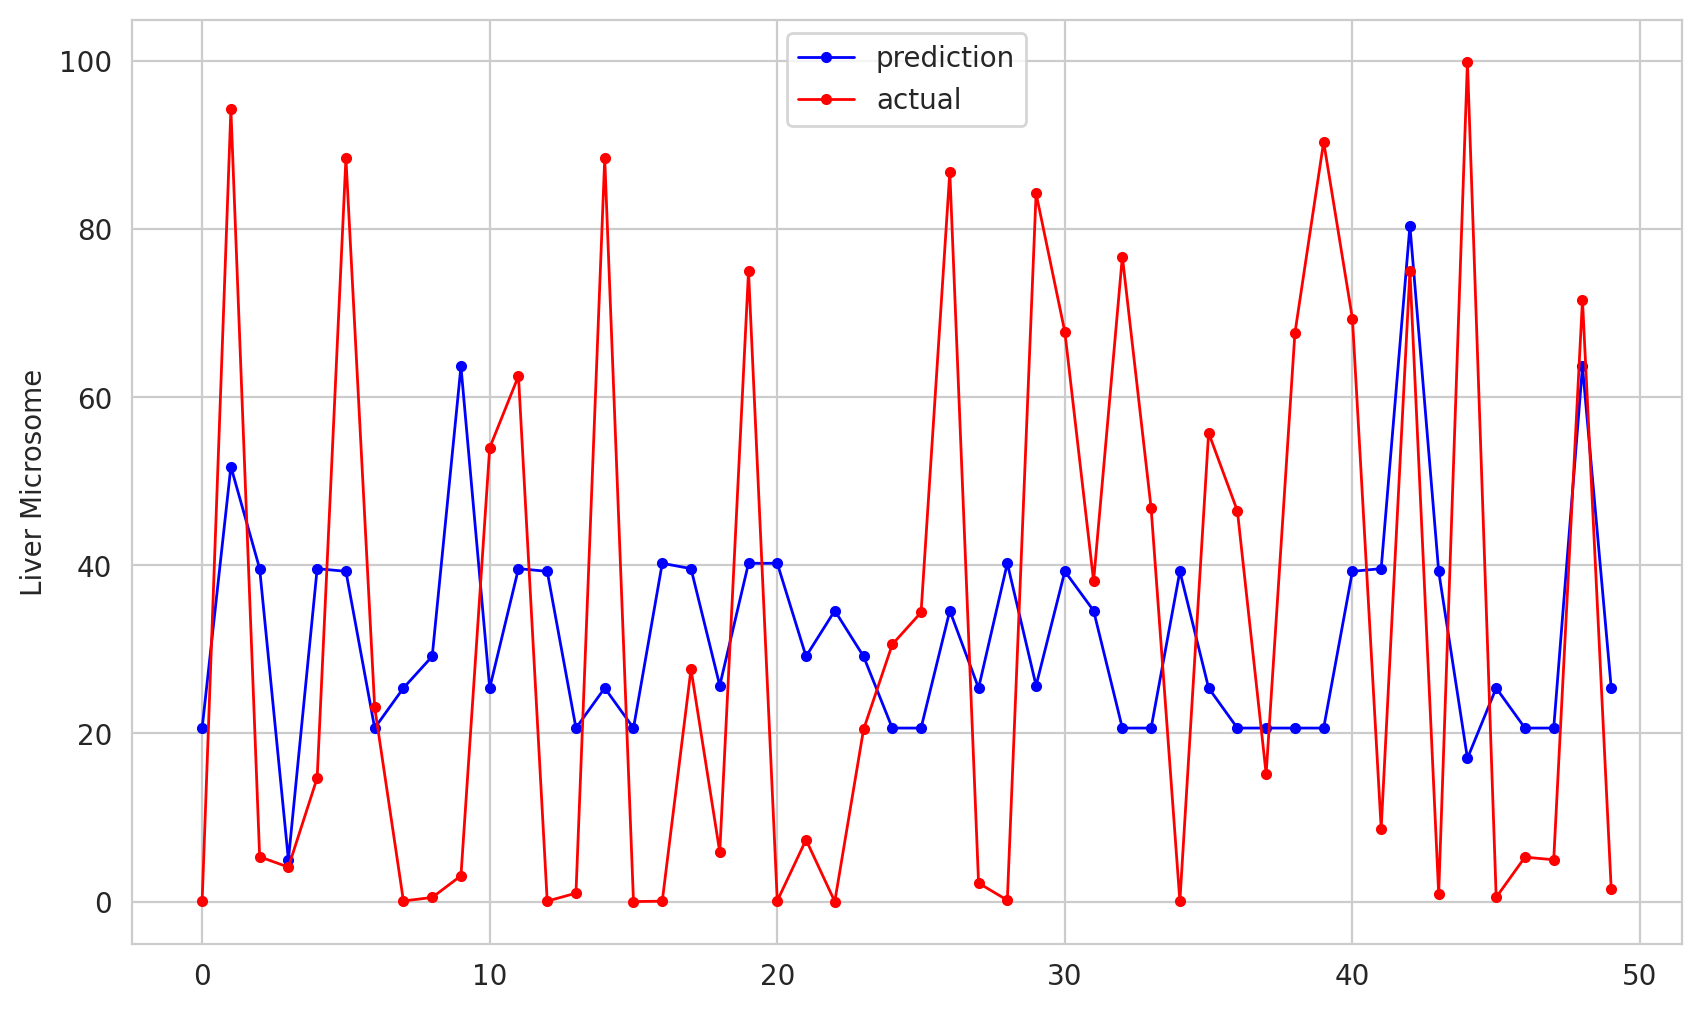

In [ ]:
# 결정 트리 회귀 모델
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(Xm_train, ym_train)
y_pred = dtr.predict(Xm_val)
show_reg_result(ym_val, y_pred)

 RMSE: 31.6002
 RMSE * 0.5 : 15.8001


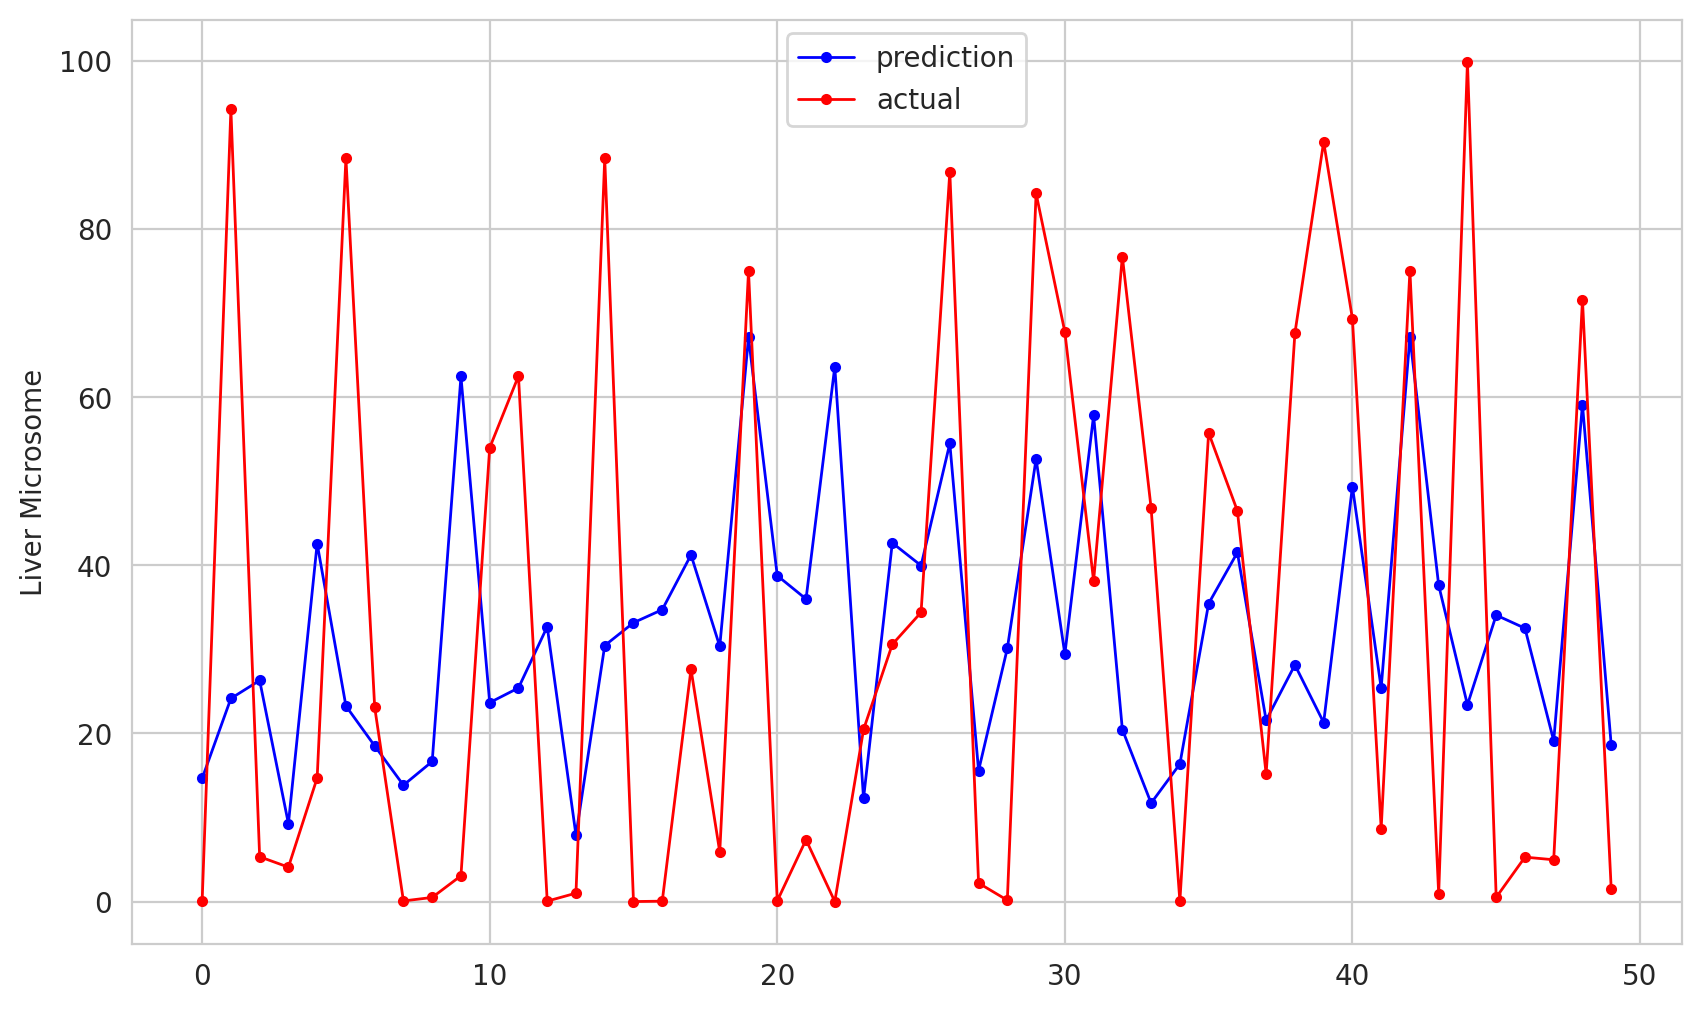

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(Xm_train, ym_train)
y_pred = rfr.predict(Xm_val)
show_reg_result(ym_val, y_pred)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1220
[LightGBM] [Info] Number of data points in the train set: 2788, number of used features: 13
[LightGBM] [Info] Start training from score 37.639585
 RMSE: 31.5912
 RMSE * 0.5 : 15.7956


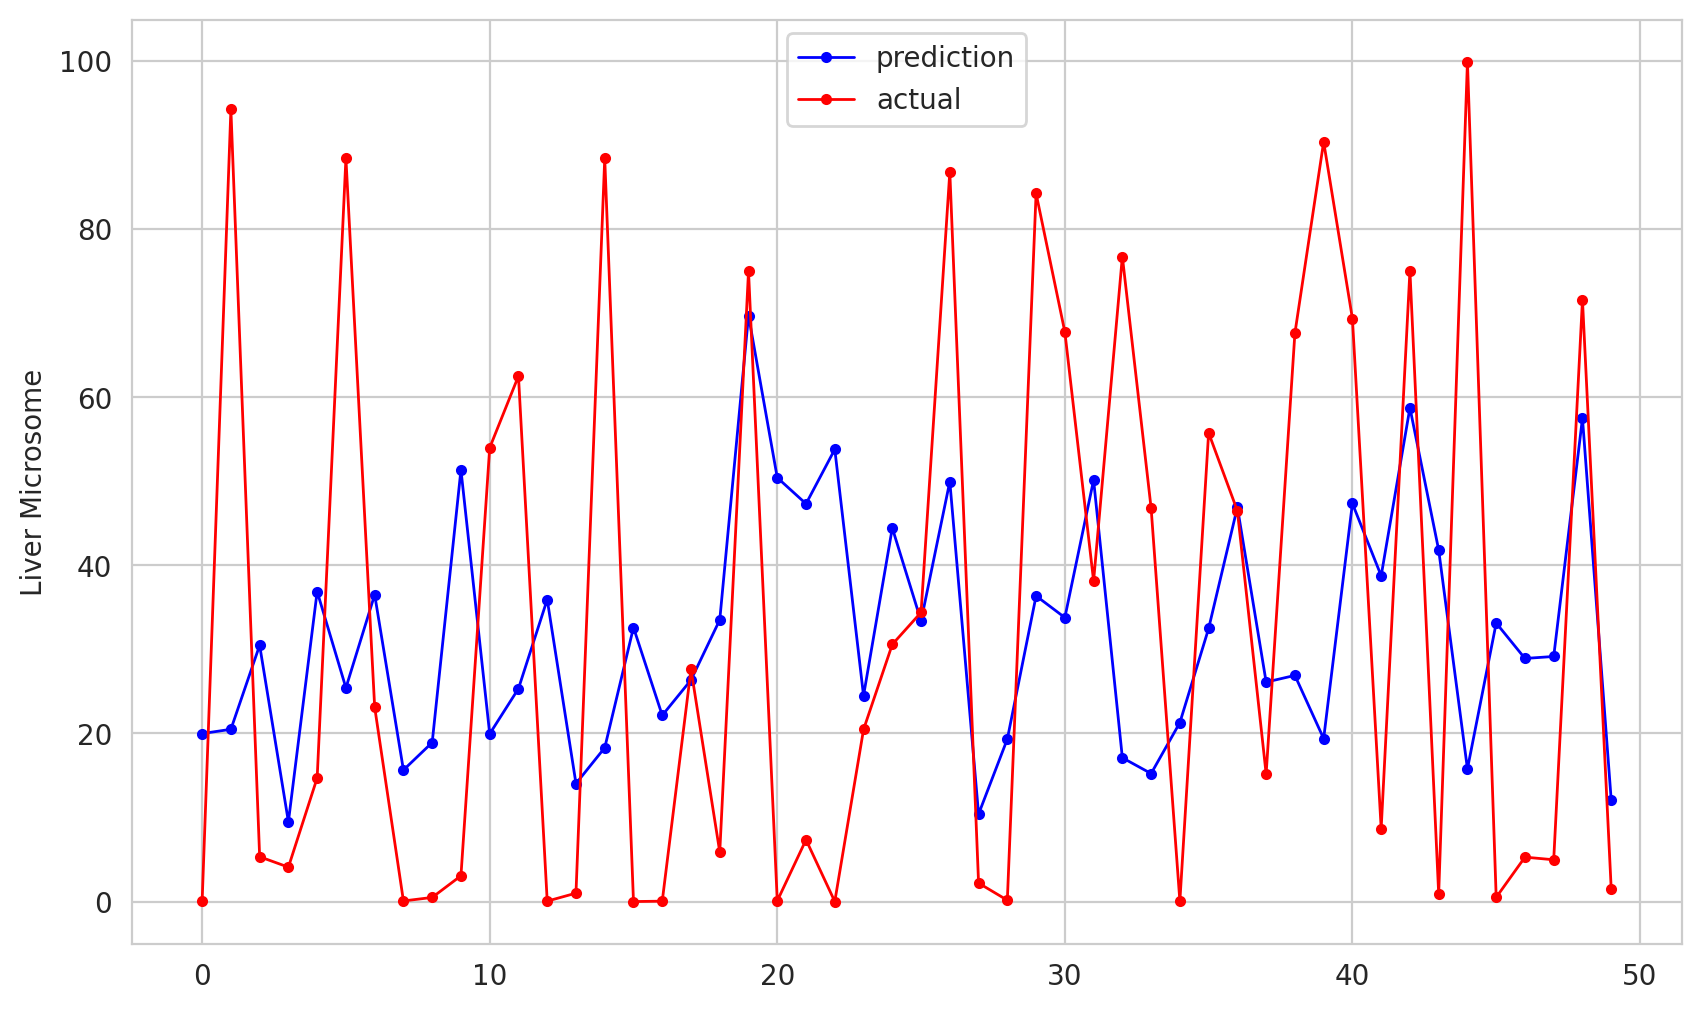

In [ ]:
from lightgbm import LGBMRegressor
lgbm_r = LGBMRegressor()
lgbm_r.fit(Xm_train, ym_train)
y_pred = lgbm_r.predict(Xm_val)
show_reg_result(ym_val, y_pred)

In [ ]:
pred_m = (dtr.predict(test_df) + rfr.predict(test_df) + lgbm_r.predict(test_df)) / 3

In [ ]:
sub_df = pd.read_csv(path + "submission.csv")

In [ ]:
len(pred_m)

482

In [ ]:
sub_df['HLM'] = pred_h
sub_df['MLM'] = pred_m

In [ ]:
sub_df.to_csv(path + 'submission.csv', index=False, encoding='utf-8-sig')

In [ ]:
sub_df.head()

,id,MLM,HLM
0,TEST_000,26.394002,54.968361
1,TEST_001,62.203145,72.563239
2,TEST_002,28.833825,47.241156
3,TEST_003,59.752961,72.344267
4,TEST_004,60.371519,77.817405


# AlogP 구해보기.

In [ ]:
x_columns_ = ['MLM', 'HLM', 'Molecular_Weight',
       'Num_H_Acceptors', 'Num_H_Donors', 'Num_RotatableBonds', 'LogD',
       'Molecular_PolarSurfaceArea', 'num_of_atoms', 'num_of_heavy_atoms',
       'num_of_C_atoms', 'num_of_O_atoms','num_of_N_atoms', 'num_of_Cl_atoms']
y_columns_ = 'AlogP'

In [ ]:
len(x_columns_)

14

In [ ]:
X = df[x_columns_]
y = df[y_columns_].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [ ]:
def reg_result(y_test, y_pred, N=50):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    R2 = r2_score(y_test, y_pred)
    max_err = np.abs(y_test - y_pred).max()

    print('R2:', round(R2,4))
    print('MAE:', round(mae, 4))
    print('RMSE:', round(rmse,4))
    print('Max error:', round(max_err, 4))

    # 일부 실제값과 예측값 샘플을 plot으로 비교하여 그려본다 (N 개)

    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
      plt.legend()
      plt.ylabel('AlogP')
      plt.show()

In [ ]:
def reg_result(y_test, y_pred, N=50):
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print(f'RMSE:', round(rmse, 4))
    print(f'RMSE * 0.5 :', round(rmse * 0.5, 4))

    if N > 0:
      plt.figure(figsize=(10, 6))
      plt.plot(y_pred[:N], ".b-", label="prediction", linewidth=1.0)
      plt.plot(y_test[:N], '.r-', label="actual", linewidth=1.0)
      plt.legend()
      plt.ylabel('AlogP')
      plt.show()

RMSE: 0.5602
RMSE * 0.5 : 0.2801


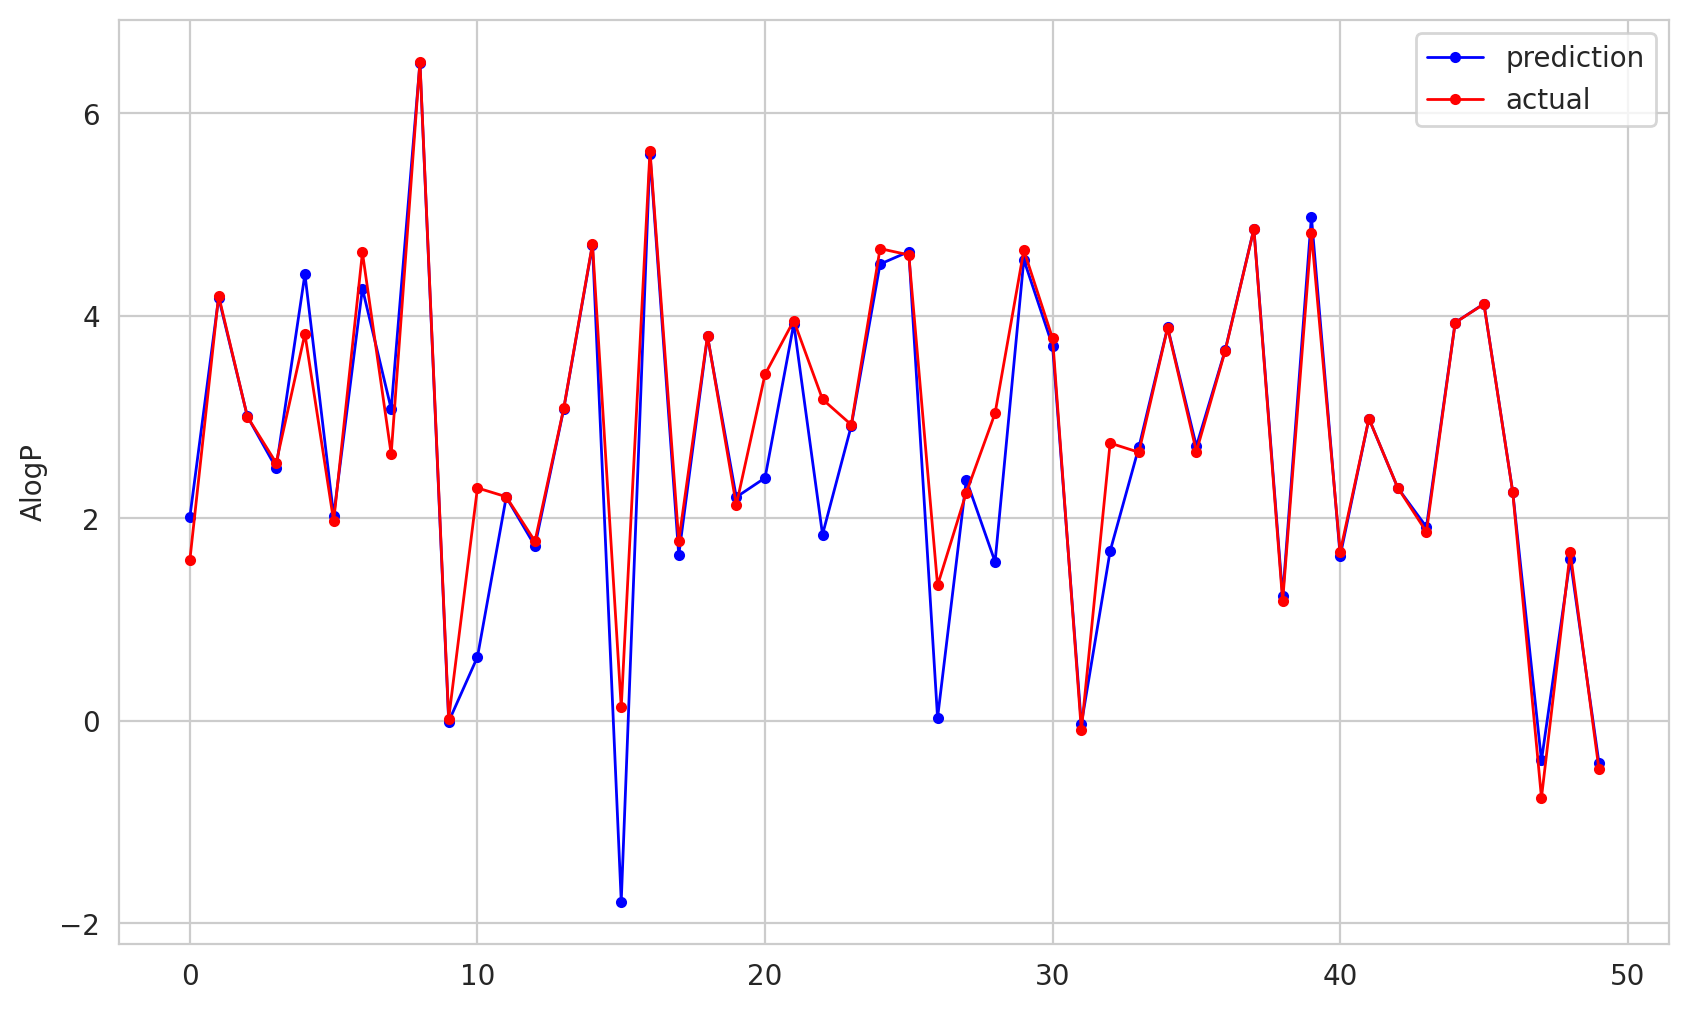

In [ ]:
# 결정 트리 회귀 모델
dtr = DecisionTreeRegressor(max_depth=17)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_test)
reg_result(y_test, y_pred)

 RMSE: 0.4594
 RMSE * 0.5 : 0.2297


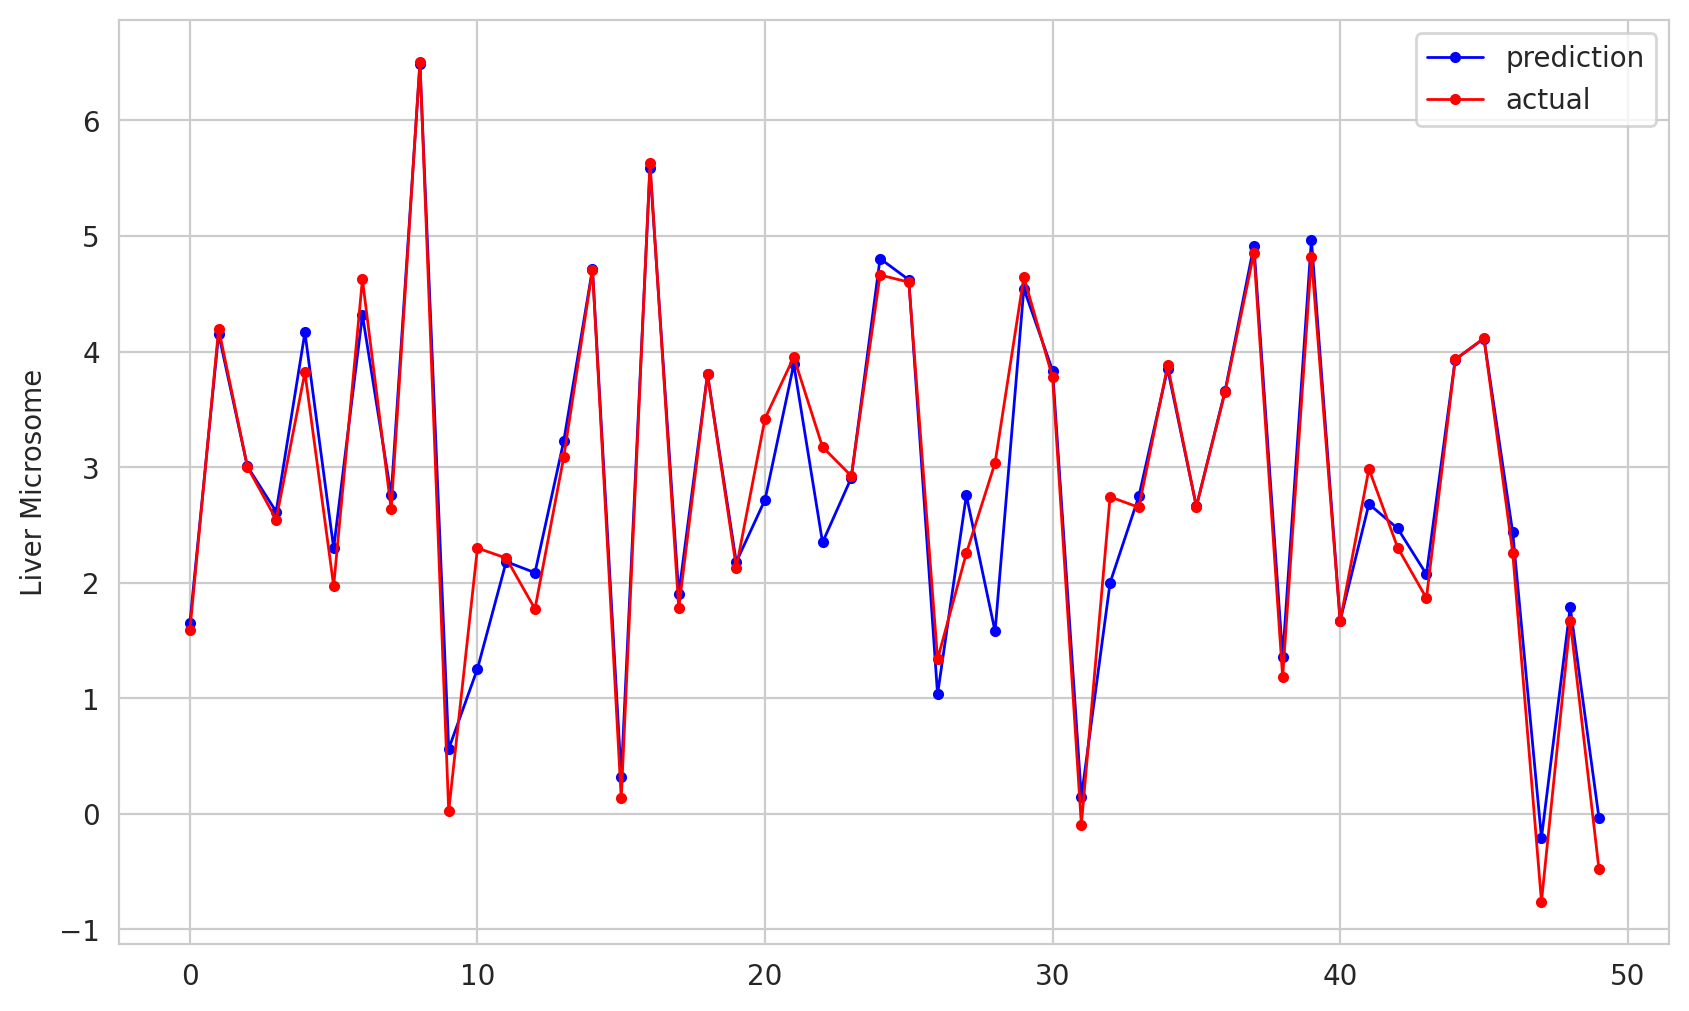

In [ ]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
show_reg_result(y_test, y_pred)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1479
[LightGBM] [Info] Number of data points in the train set: 2796, number of used features: 14
[LightGBM] [Info] Start training from score 2.841624
 RMSE: 0.424
 RMSE * 0.5 : 0.212


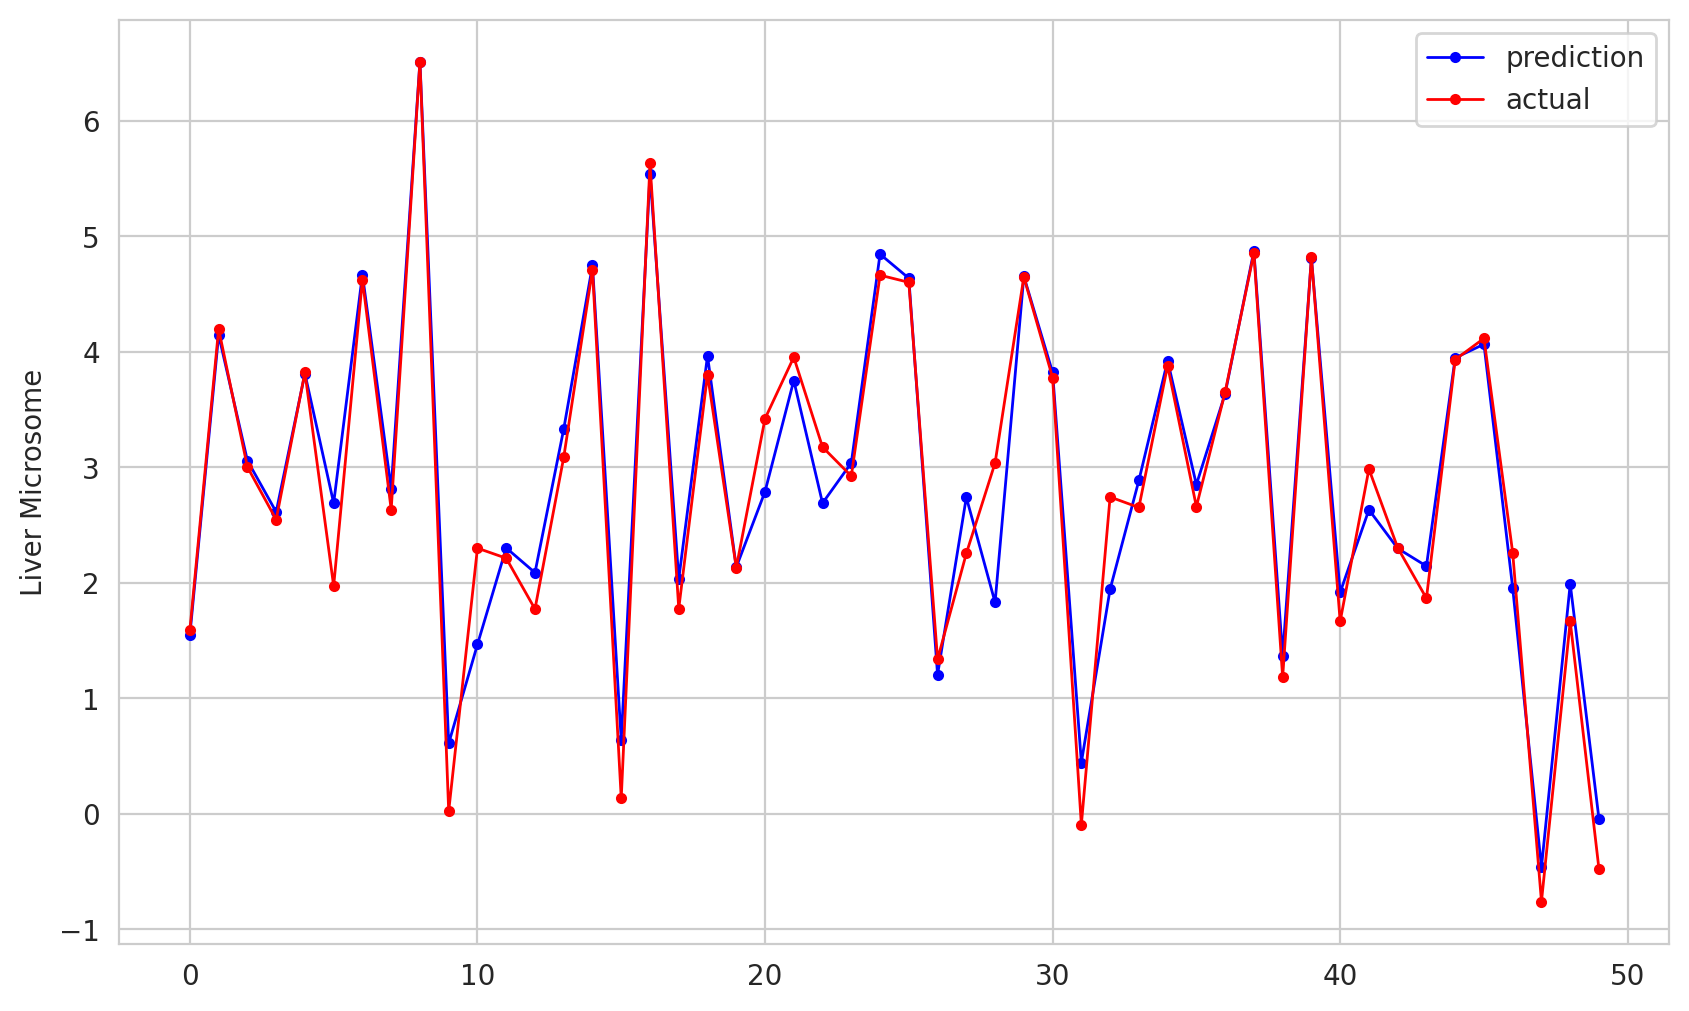

In [ ]:
lgbm_r = LGBMRegressor()
lgbm_r.fit(X_train, y_train)
y_pred = lgbm_r.predict(X_test)
show_reg_result(y_test, y_pred)

In [ ]:
df_ = pd.read_csv(path + 'train.csv')

In [ ]:
df_['mol'] = df_['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))
df_['mol'] = df_['mol'].apply(lambda x: Chem.AddHs(x))
df_['num_of_atoms'] = df_['mol'].apply(lambda x: x.GetNumAtoms())
df_['num_of_heavy_atoms'] = df_['mol'].apply(lambda x: x.GetNumHeavyAtoms())

In [ ]:
number_of_atoms(['C','O', 'N', 'Cl'], df_)

In [ ]:
df_.loc[idx_null][x_columns_]

,MLM,HLM,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms
2796,0.549,0.2,418.566,5,1,7,4.634,72.83,68,30,25,5,0,0
3387,0.240,3.2,390.450,3,0,5,4.911,34.06,52,29,24,2,2,0


In [ ]:
temp = df_.loc[idx_null][x_columns_]

In [ ]:
temp.index[0]

2788

In [ ]:
for i in range(len(temp)):
    print('-----' * 5)
    print(f'index : {temp.index[i]}')
    print('-----' * 5)
    print(f"decision tree의 AlogP : {dtr.predict(temp.iloc[[i]])}")
    print(f"random forest의 AlogP : {rfr.predict(temp.iloc[[i]])}")
    print(f"lightgbm의　AlogP : {lgbm_r.predict(temp.iloc[[i]])}")

-------------------------
index : 2796
-------------------------
decision tree의 AlogP : [4.6335]
random forest의 AlogP : [4.66345]
lightgbm의　AlogP : [4.66893083]
-------------------------
index : 3387
-------------------------
decision tree의 AlogP : [4.909]
random forest의 AlogP : [4.75133]
lightgbm의　AlogP : [4.98091615]


In [ ]:
len(x_columns)

7

In [ ]:
len(Xh_train.columns)

7